In [102]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import xgboost as xgb
import seaborn as sns
sns.set_style('darkgrid')

### Load Data 

In [103]:
df = pd.read_csv('loan_2015_clean_update.csv')

In [104]:
df.shape

(381716, 93)

In [105]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381716 entries, 0 to 381715
Data columns (total 93 columns):
totalilhighcreditlimit        381716 non-null float64
allutil                       19292 non-null float64
numtl120dpd2m                 363867 non-null float64
verificationstatusjoint       409 non-null object
mthssincerecentbc             378203 non-null float64
id                            381716 non-null int64
inqlast12m                    19292 non-null float64
emplength                     359441 non-null object
mortacc                       381716 non-null float64
numtl30dpd                    381716 non-null float64
openacc6m                     19292 non-null float64
pubrecbankruptcies            381716 non-null float64
mthssincerecentinq            342273 non-null float64
numrevaccts                   381715 non-null float64
numactvrevtl                  381716 non-null float64
dti                           381714 non-null float64
mthssincelastdelinq           19735

In [106]:
all_null_feature = []

ob_feature = ['verificationstatusjoint', 'emplength', 'intrate', 'homeownership', 'subgrade', 'desc', 'applicationtype', 'verificationstatus', 'purpose', 'grade', 'earliestcrline', 'revolutil', 'addrstate', 'term', 'emptitle', 'initialliststatus', 'zipcode', 'issued'] 

num_feature = ['totalilhighcreditlimit', 'allutil', 'numtl120dpd2m', 'mthssincerecentbc', 'id', 'inqlast12m', 'mortacc', 'numtl30dpd', 'openacc6m', 'pubrecbankruptcies', 'mthssincerecentinq', 'numrevaccts', 'numactvrevtl', 'dti', 'mthssincelastdelinq', 'mthssincelastmajorderog', 'openacc', 'delinqamnt', 'mthssincerecentbcdlq', 'pcttlnvrdlq', 'accopenpast24mths', 'annualincjoint', 'loanamnt', 'mosinrcnttl', 'openrv12m', 'accnowdelinq', 'totalbalil', 'mthssincercntil', 'collections12mthsexmed', 'avgcurbal', 'delinq2yrs', 'dtijoint', 'numoprevtl', 'annualinc', 'numrevtlbalgt0', 'mosinoldilacct', 'openil12m', 'mosinrcntrevtlop', 'taxliens', 'totalrevhilim', 'openactil', 'numacctsever120pd', 'percentbcgt75', 'totalbclimit', 'maxbalbc', 'openrv24m', 'totalacc', 'mthssincelastrecord', 'ficorangehigh', 'numtl90gdpd24m', 'numsats', 'revolbal', 'ficorangelow', 'totcollamt', 'totalbalexmort', 'chargeoffwithin12mths', 'totalcutl', 'inqfi', 'mosinoldrevtlop', 'numtloppast12m', 'bcutil', 'numiltl', 'installment', 'inqlast6mths', 'pubrec', 'tothicredlim', 'totcurbal', 'numbcsats', 'mthssincerecentrevoldelinq', 'ilutil', 'numactvbctl', 'openil24m', 'numbctl', 'bcopentobuy', 'loanstatus']

In [107]:
print('all_null_feature length:', len(all_null_feature))
print('ob_feature:', len(ob_feature))
print('num_feature:', len(num_feature))

all_null_feature length: 0
ob_feature: 18
num_feature: 75


In [108]:
df['loanstatus'].value_counts()

0    304622
1     77094
Name: loanstatus, dtype: int64

In [109]:
ob_feature.remove('applicationtype')# 99.9% are Individual
ob_feature.remove('desc') #'desc' is similar to purpose
num_feature.remove('id')
print('ob_feature:', len(ob_feature))

ob_feature: 16


In [110]:
select_feature = ob_feature + num_feature
len(select_feature)

90

#### Only use the term of 36 month as they are already due now and the results are suposed to be fully paid or  charged off

In [111]:
df['term'].value_counts()

 36 months    283167
 60 months     98549
Name: term, dtype: int64

In [112]:
df = df.query('term==" 36 months"')

In [113]:
df.shape

(283167, 93)

In [114]:
ob_feature.remove('term')

In [115]:
select_feature = ob_feature + num_feature
len(select_feature)

89

### Label Target 

In [116]:
print(df['loanstatus'].value_counts())
print(df['loanstatus'].value_counts(normalize=True)) 
#1: charged off(more than 4 months late)   2: fully paid

0    240991
1     42176
Name: loanstatus, dtype: int64
0    0.851056
1    0.148944
Name: loanstatus, dtype: float64


### Split into training and testing data by 'issued' 

In [99]:
issued = df['issued'].unique()
issued

array(['Dec-2015', 'Nov-2015', 'Oct-2015', 'Sep-2015', 'Aug-2015',
       'Jul-2015', 'Jun-2015', 'May-2015', 'Apr-2015', 'Mar-2015',
       'Feb-2015', 'Jan-2015'], dtype=object)

In [117]:
df = df[select_feature+['id']][:-2]
df.shape
# delete the last two rows as they are all null

(283165, 90)

In [118]:
df['train_flg'] = df.issued.apply(lambda x: 0 if x in issued[:1] else 1)
df.train_flg.value_counts()
# Dec:1 as testing data   others: 0 as traing data

1    252828
0     30337
Name: train_flg, dtype: int64

## Feature Engineering & cleaning 

In [119]:
# convert all ob_feature into numerical feature

In [120]:
df.head()

,verificationstatusjoint,emplength,intrate,homeownership,subgrade,verificationstatus,purpose,grade,earliestcrline,revolutil,...,numbcsats,mthssincerecentrevoldelinq,ilutil,numactvbctl,openil24m,numbctl,bcopentobuy,loanstatus,id,train_flg
0,NaN,10+ years,11.99%,MORTGAGE,C1,Not Verified,small_business,C,Dec-1999,19.2%,...,13.0,6.0,73.0,5.0,1.0,17.0,57830.0,0,68355089,0
1,NaN,10+ years,13.99%,MORTGAGE,C4,Not Verified,debt_consolidation,C,Aug-2003,29.7%,...,2.0,69.0,36.0,2.0,1.0,5.0,1506.0,0,68407277,0
4,NaN,4 years,13.44%,RENT,C3,Source Verified,debt_consolidation,C,Oct-1987,68.4%,...,2.0,NaN,99.0,2.0,0.0,2.0,844.0,0,68426831,0
5,NaN,10+ years,9.17%,MORTGAGE,B2,Not Verified,debt_consolidation,B,Jun-1990,84.5%,...,4.0,NaN,63.0,4.0,2.0,5.0,0.0,0,68476668,0
6,NaN,3 years,12.88%,MORTGAGE,C2,Not Verified,other,C,Jun-1996,67.2%,...,8.0,NaN,67.0,7.0,2.0,11.0,7940.0,0,68338832,0


In [121]:
# datatime to numerical feature

In [122]:
df.earliestcrline.unique()

array(['Dec-1999', 'Aug-2003', 'Oct-1987', 'Jun-1990', 'Jun-1996',
       'Apr-2002', 'Nov-1994', 'Feb-1999', 'May-1984', 'Mar-2005',
       'Dec-2001', 'May-2000', 'Oct-2011', 'May-1991', 'May-2001',
       'Dec-1985', 'Jul-2011', 'Jun-2002', 'May-1994', 'Feb-2002',
       'Aug-2004', 'Oct-1996', 'Jun-2007', 'Jul-2001', 'May-1992',
       'Jul-2004', 'Jan-2001', 'Sep-2004', 'Jun-2005', 'Nov-2001',
       'Sep-2006', 'Feb-2004', 'Oct-1998', 'Aug-1987', 'Apr-2001',
       'Aug-1997', 'Jan-1999', 'Feb-1996', 'Dec-1987', 'Sep-1994',
       'Nov-2002', 'Feb-2012', 'Oct-2006', 'Apr-1993', 'Oct-2004',
       'Apr-2005', 'Dec-2002', 'Jan-1998', 'Jun-2001', 'Sep-2007',
       'Mar-2001', 'Apr-2003', 'May-2008', 'Apr-1994', 'Jan-2002',
       'May-2002', 'Nov-2000', 'Nov-2009', 'Sep-2003', 'Dec-1997',
       'Aug-2008', 'Aug-2009', 'May-2006', 'May-1985', 'Jun-1999',
       'Sep-2002', 'Feb-2000', 'Nov-2003', 'Jun-2006', 'Aug-1974',
       'Feb-2010', 'Nov-2005', 'Mar-2004', 'Oct-2008', 'Oct-19

In [123]:
# convert to number of months to Dec 2015

In [124]:
cl_month = df.earliestcrline.apply(lambda x: x.split('-')[0])
cl_year = df.earliestcrline.apply(lambda x: x.split('-')[1])

In [125]:
print(cl_month.unique())
print(cl_year.unique())

['Dec' 'Aug' 'Oct' 'Jun' 'Apr' 'Nov' 'Feb' 'May' 'Mar' 'Jul' 'Jan' 'Sep']
['1999' '2003' '1987' '1990' '1996' '2002' '1994' '1984' '2005' '2001'
 '2000' '2011' '1991' '1985' '2004' '2007' '1992' '2006' '1998' '1997'
 '2012' '1993' '2008' '2009' '1974' '2010' '1995' '1986' '1977' '1983'
 '1989' '1979' '1988' '1980' '1982' '1968' '1981' '1978' '1976' '1975'
 '1972' '1969' '1973' '1970' '1964' '1966' '1971' '1965' '1962' '1960'
 '1967' '1963' '1961' '1959' '1958' '1950' '1956' '1955' '1953' '1951'
 '1957' '1952' '1954' '1944']


In [126]:
sorted(cl_month.unique())

['Apr',
 'Aug',
 'Dec',
 'Feb',
 'Jan',
 'Jul',
 'Jun',
 'Mar',
 'May',
 'Nov',
 'Oct',
 'Sep']

In [127]:
dic_month = {'Dec':0, 'Nov':1, 'Oct':2,'Sep':3,'Aug':4,'Jul':5,'Jun':6,'May':7,'Apr':8,'Mar':9,'Feb':10,'Jan':11}

In [128]:
df['earliestcrline_month'] = df.earliestcrline.apply(lambda x: (2015-int(x.split('-')[1]))*12+dic_month[x.split('-')[0]])
df.earliestcrline_month[:5]

0    192
1    148
4    338
5    306
6    234
Name: earliestcrline_month, dtype: int64

In [129]:
ob_feature.remove('earliestcrline')
num_feature.append('earliestcrline_month')

In [130]:
select_feature = ob_feature + num_feature
len(select_feature)

89

In [131]:
df.earliestcrline_month.dtype

dtype('int64')

### Convert "emplength" feature to numerical feature

In [132]:
print(df['emplength'].isnull().sum())
print(df['emplength'].unique())

18970
['10+ years' '4 years' '3 years' '6 years' '8 years' '2 years' '9 years'
 '< 1 year' '5 years' '1 year' nan '7 years']


In [133]:
df['emplength'].value_counts()

10+ years    89687
2 years      25889
< 1 year     24089
3 years      23109
1 year       19240
5 years      16899
4 years      16754
8 years      14270
7 years      12162
6 years      11182
9 years      10914
Name: emplength, dtype: int64

In [134]:
#way 1(not run)
#df['emplength'].replace('n/a', np.nan, inplace=True)
#df['emplength'].replace('< 1 year', '0', inplace=True)
#df['emplength'].replace(to_replace='[^0-9]+', value='', inplace=True, regex=True)
#df.emplength.fillna(value=-999,inplace=True)
#df['emplength'] = df['emplength'].astype(int)

In [135]:
#way 2(run)
df['emplength'].replace('< 1 year', '0 year', inplace=True)
df['emplength'].replace('10+ years', '10 years', inplace=True)
df['emplength'].fillna(value='-999 years', inplace=True)
df['emplength'] = df['emplength'].apply(lambda x: x.split()[0])
df['emplength'] = df['emplength'].astype('int')

In [136]:
#way 2(run)
df['emplength'].unique()

array([  10,    4,    3,    6,    8,    2,    9,    0,    5,    1, -999,
          7])

In [137]:
ob_feature.remove('emplength')
num_feature.append('emplength')

In [138]:
print(len(ob_feature),len(num_feature),len(select_feature))

13 76 89


### % to numerical feature: intrate, revolutil 

In [139]:
df['intrate'] = df.intrate.apply(lambda x: float(x.replace('%','')))
df['revolutil']=df.revolutil.apply(lambda x: float(str(x).replace('%','')))

In [140]:
df['intrate'][:4]

0    11.99
1    13.99
4    13.44
5     9.17
Name: intrate, dtype: float64

In [141]:
df['revolutil'][:3]

0    19.2
1    29.7
4    68.4
Name: revolutil, dtype: float64

In [142]:
ob_feature.remove('intrate')
num_feature.append('intrate')
ob_feature.remove('revolutil')
num_feature.append('revolutil')
print(len(ob_feature),len(num_feature),len(select_feature))

11 78 89


### ordinal feature encoding : grade, subgrade

In [143]:
df.subgrade.unique()

array(['C1', 'C4', 'C3', 'B2', 'C2', 'A2', 'B5', 'B1', 'E3', 'A4', 'A1',
       'C5', 'B4', 'B3', 'D1', 'D3', 'A5', 'D2', 'E1', 'D4', 'E5', 'A3',
       'F1', 'D5', 'F2', 'F3', 'E2', 'E4', 'F4', 'G2', 'F5', 'G1', 'G3',
       'G4', 'G5'], dtype=object)

In [144]:
grade_dic = {'A':1, 'B':2, 'C':3, 'D':4, 'E':5, 'F':6, 'G':7}

In [145]:
df['grade'] = df.grade.map(grade_dic)

In [146]:
df['subgrade'] = df.subgrade.apply(lambda x:(grade_dic[x[0]]-1)*5+int(x[1]))
df['subgrade'].unique()

array([11, 14, 13,  7, 12,  2, 10,  6, 23,  4,  1, 15,  9,  8, 16, 18,  5,
       17, 21, 19, 25,  3, 26, 20, 27, 28, 22, 24, 29, 32, 30, 31, 33, 34,
       35])

In [147]:
df['grade'].unique()

array([3, 2, 1, 5, 4, 6, 7])

In [148]:
ob_feature.remove('grade')
num_feature.append('grade')
ob_feature.remove('subgrade')
num_feature.append('subgrade')
print(len(ob_feature),len(num_feature),len(select_feature))

9 80 89


### High cardinality features

In [149]:
# hight cardinality: have large amount of unique value

### zipcode-- frequency encoding

In [150]:
df['zipcode'][:5]

0    577xx
1    190xx
4    300xx
5    550xx
6    275xx
Name: zipcode, dtype: object

In [151]:
df['zipcode'] = df.zipcode.apply(lambda x: int(x[:3]))
df['zipcode'][:5]

0    577
1    190
4    300
5    550
6    275
Name: zipcode, dtype: int64

In [152]:
df['zipcode'].unique()

array([577, 190, 300, 550, 275, 160,  29, 293, 462, 299, 226, 100, 214,
       125, 672, 354, 238, 750, 993, 215, 606, 984, 331, 330, 441, 142,
       493, 644, 453,  15, 347, 430, 134,  54, 967, 381, 117, 434, 787,
       236, 472,  16,  85, 482, 670, 850,  30,  23,  70, 220, 280, 604,
       346, 377, 958, 681, 439, 661, 477, 973, 431, 282, 910, 349, 986,
       544, 112, 197, 355, 551, 498, 481,  10,  64, 357,  88, 913, 930,
       480, 327, 805, 111, 770, 926, 711, 751, 440, 322, 172, 230, 250,
       113, 894,  31, 234,  80,  28, 945, 208, 594, 104, 158, 941, 370,
       922, 191, 900, 906,  20, 210, 468, 957, 490, 294, 207, 786, 563,
       463, 301, 436, 231, 607, 554, 773, 324, 600, 164, 980, 956, 341,
       366, 815, 917, 928, 825, 495,  21, 270, 140, 380, 778, 618, 376,
       743, 303,  27, 763, 939, 201, 222, 116, 240, 365, 890, 760, 302,
       416, 653, 610, 350,  19, 641, 244,  78, 924, 181, 891, 329, 968,
       454, 404, 820, 953, 774, 286, 308, 631, 902, 193, 310, 98

In [153]:
int('     50')

50

In [154]:
zipcode_freq = df.groupby('zipcode').size().reset_index()
zipcode_freq[:5]

,zipcode,0
0,7,1
1,8,2
2,10,434
3,11,144
4,12,99


In [155]:
zipcode_freq.shape

(901, 2)

In [156]:
zipcode_freq.columns = ['zipcode', 'zipcode_freq']
zipcode_freq[:3]

,zipcode,zipcode_freq
0,7,1
1,8,2
2,10,434


In [157]:
df = pd.merge(df, zipcode_freq, how='left', on='zipcode')
df[['zipcode','zipcode_freq']][:5]

,zipcode,zipcode_freq
0,577,131
1,190,926
2,300,2723
3,550,612
4,275,1083


In [158]:
ob_feature.remove('zipcode')
num_feature.append('zipcode')
num_feature.append('zipcode_freq')
print(len(ob_feature),len(num_feature),len(select_feature))

8 82 89


In [159]:
ob_feature

['verificationstatusjoint',
 'homeownership',
 'verificationstatus',
 'purpose',
 'addrstate',
 'emptitle',
 'initialliststatus',
 'issued']

In [160]:
df.loanstatus[:5]

0    0
1    0
2    0
3    0
4    0
Name: loanstatus, dtype: int64

###  addrstate-- freqency encoding

In [161]:
addrstate_freq = df.groupby('addrstate').size().reset_index()
addrstate_freq.columns = ['addrstate', 'addrstate_freq']
df = pd.merge(df, addrstate_freq, how='left', on='addrstate')
df[['addrstate', 'addrstate_freq']][:5]

,addrstate,addrstate_freq
0,SD,550
1,PA,9508
2,GA,9391
3,MN,5094
4,NC,7649


In [162]:
ob_feature.remove('addrstate')
num_feature.append('addrstate_freq')
print(len(ob_feature),len(num_feature))

7 83


In [163]:
ob_feature

['verificationstatusjoint',
 'homeownership',
 'verificationstatus',
 'purpose',
 'emptitle',
 'initialliststatus',
 'issued']

### emptitle-- frequency encoding 

In [164]:
len(df['emptitle'].unique())

86157

In [165]:
emptitle_freq = df.groupby('emptitle').size().reset_index()
emptitle_freq.columns = ['emptitle','emptitle_freq']
df = pd.merge(df,emptitle_freq, how='left', on='emptitle')
df[['emptitle','emptitle_freq']][:5]

,emptitle,emptitle_freq
0,Engineer,1027.0
1,leadman,17.0
2,Veterinary Tecnician,1.0
3,Vice President of Recruiting Operations,1.0
4,Logistics Manager,77.0


In [166]:
ob_feature.remove('emptitle')
num_feature.append('emptitle_freq')
print(len(ob_feature),len(num_feature))

6 84


In [167]:
ob_feature

['verificationstatusjoint',
 'homeownership',
 'verificationstatus',
 'purpose',
 'initialliststatus',
 'issued']

### one-hot encoding  

In [168]:
#A dummy variable is a variable that takes values of 0 and 1
# one-hot encoding: convert all the remaining ob_feature into dummy 

In [169]:
dummy_feature = ['verificationstatusjoint', 'homeownership','verificationstatus','purpose',
                  'initialliststatus']

In [170]:
df_dummy = pd.get_dummies(df[dummy_feature])

In [171]:
OHE_feature = list(df_dummy.columns.values)
OHE_feature

['verificationstatusjoint_Not Verified',
 'homeownership_ANY',
 'homeownership_MORTGAGE',
 'homeownership_OWN',
 'homeownership_RENT',
 'verificationstatus_Not Verified',
 'verificationstatus_Source Verified',
 'verificationstatus_Verified',
 'purpose_car',
 'purpose_credit_card',
 'purpose_debt_consolidation',
 'purpose_educational',
 'purpose_home_improvement',
 'purpose_house',
 'purpose_major_purchase',
 'purpose_medical',
 'purpose_moving',
 'purpose_other',
 'purpose_renewable_energy',
 'purpose_small_business',
 'purpose_vacation',
 'purpose_wedding',
 'initialliststatus_f',
 'initialliststatus_w']

In [172]:
len(OHE_feature)

24

In [173]:
df = pd.concat([df,df_dummy], axis=1)

In [174]:
df.shape

(283165, 119)

In [175]:
for feat in dummy_feature:
    ob_feature.remove(feat)

In [176]:
ob_feature

['issued']

In [177]:
num_feature.remove('loanstatus')# it is label feature

In [178]:
select_feature = num_feature+OHE_feature

In [179]:
print(len(select_feature))
print(select_feature)

107
['totalilhighcreditlimit', 'allutil', 'numtl120dpd2m', 'mthssincerecentbc', 'inqlast12m', 'mortacc', 'numtl30dpd', 'openacc6m', 'pubrecbankruptcies', 'mthssincerecentinq', 'numrevaccts', 'numactvrevtl', 'dti', 'mthssincelastdelinq', 'mthssincelastmajorderog', 'openacc', 'delinqamnt', 'mthssincerecentbcdlq', 'pcttlnvrdlq', 'accopenpast24mths', 'annualincjoint', 'loanamnt', 'mosinrcnttl', 'openrv12m', 'accnowdelinq', 'totalbalil', 'mthssincercntil', 'collections12mthsexmed', 'avgcurbal', 'delinq2yrs', 'dtijoint', 'numoprevtl', 'annualinc', 'numrevtlbalgt0', 'mosinoldilacct', 'openil12m', 'mosinrcntrevtlop', 'taxliens', 'totalrevhilim', 'openactil', 'numacctsever120pd', 'percentbcgt75', 'totalbclimit', 'maxbalbc', 'openrv24m', 'totalacc', 'mthssincelastrecord', 'ficorangehigh', 'numtl90gdpd24m', 'numsats', 'revolbal', 'ficorangelow', 'totcollamt', 'totalbalexmort', 'chargeoffwithin12mths', 'totalcutl', 'inqfi', 'mosinoldrevtlop', 'numtloppast12m', 'bcutil', 'numiltl', 'installment', '

In [180]:
df.to_csv('loan_2015_ready.csv', index=False)

In [181]:
print('done')

done


## XGBoost

In [376]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split

In [377]:
df = pd.read_csv('loan_2015_ready.csv')
df.shape

/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(283165, 118)

In [378]:
select_feature = ['totalilhighcreditlimit', 'allutil', 'numtl120dpd2m', 'mthssincerecentbc', 'inqlast12m', 'mortacc', 'numtl30dpd', 'openacc6m', 'pubrecbankruptcies', 'mthssincerecentinq', 'numrevaccts', 'numactvrevtl', 'dti', 'mthssincelastdelinq', 'mthssincelastmajorderog', 'openacc', 'delinqamnt', 'mthssincerecentbcdlq', 'pcttlnvrdlq', 'accopenpast24mths', 'annualincjoint', 'loanamnt', 'mosinrcnttl', 'openrv12m', 'accnowdelinq', 'totalbalil', 'mthssincercntil', 'collections12mthsexmed', 'avgcurbal', 'delinq2yrs', 'dtijoint', 'numoprevtl', 'annualinc', 'numrevtlbalgt0', 'mosinoldilacct', 'openil12m', 'mosinrcntrevtlop', 'taxliens', 'totalrevhilim', 'openactil', 'numacctsever120pd', 'percentbcgt75', 'totalbclimit', 'maxbalbc', 'openrv24m', 'totalacc', 'mthssincelastrecord', 'ficorangehigh', 'numtl90gdpd24m', 'numsats', 'revolbal', 'ficorangelow', 'totcollamt', 'totalbalexmort', 'chargeoffwithin12mths', 'totalcutl', 'inqfi', 'mosinoldrevtlop', 'numtloppast12m', 'bcutil', 'numiltl', 'installment', 'inqlast6mths', 'pubrec', 'tothicredlim', 'totcurbal', 'numbcsats', 'mthssincerecentrevoldelinq', 'ilutil', 'numactvbctl', 'openil24m', 'numbctl', 'bcopentobuy', 'earliestcrline_month', 'emplength', 'intrate', 'revolutil', 'grade', 'subgrade', 'zipcode', 'zipcode_freq', 'addrstate_freq', 'emptitle_freq', 'verificationstatusjoint_Not Verified', 'homeownership_ANY', 'homeownership_MORTGAGE', 'homeownership_OWN', 'homeownership_RENT', 'verificationstatus_Not Verified', 'verificationstatus_Source Verified', 'verificationstatus_Verified', 'purpose_car', 'purpose_credit_card', 'purpose_debt_consolidation', 'purpose_educational', 'purpose_home_improvement', 'purpose_house', 'purpose_major_purchase', 'purpose_medical', 'purpose_moving', 'purpose_other', 'purpose_renewable_energy', 'purpose_small_business', 'purpose_vacation', 'purpose_wedding', 'initialliststatus_f', 'initialliststatus_w']
feat = select_feature
len(feat)

107

In [379]:
df_train = df.query("train_flg==1")
df_test = df.query("train_flg==0")
df_train.shape,df_test.shape

((252828, 118), (30337, 118))

In [380]:
df_train[feat].shape

(252828, 107)

In [381]:
x_train, x_valid, y_train, y_valid = train_test_split(df_train[feat], df_train.loanstatus,
                                                      test_size=0.33, random_state=1234, 
                                                      stratify = df_train.loanstatus)

In [382]:
x_test, y_test = df_test[feat], df_test.loanstatus

In [383]:
#The data is stored in a DMatrix object.
dtrain = xgb.DMatrix(x_train, y_train, missing=np.NAN)
dvalid = xgb.DMatrix(x_valid, y_valid, missing=np.NAN)
dtest = xgb.DMatrix(x_test, y_test, missing=np.NAN)

/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/anaconda3/lib/python3.6/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


In [384]:
params = {'objective': 'binary:logistic',#binary:logistic-return probability,multi:softmax-mutiplt clssification,return classes
          #multi:softprob-return probability for each class. select the type of model to run at each iteration
          'booster':'gbtree',#default, tree base
          'eta': 0.05, # like learning rate. Typical final 0.01-0.2, default=0.3
          'max_depth': 6,#Typical values: 3-10
          'subsample': 0.632,#Typical values: 0.5-1, to prevent overfitting
          'colsample_bytree':0.7, # number of features randomly picked
          'silent':0, #0:wont print running messages, 1:will do
          'seed':1234,#Can be used for generating reproducible results and also for parameter tuning
          'eval_metric':'auc',#The metric to be used for validation data.
         # a binary classification problem. AUC is a good way for evaluation for this type of problems
          'min_child_weight':5
         #'gamma':Minimum loss reduction required to make a further partition on a leaf node of the tree.
         }


In [385]:
watchlist = [(dtrain,'train'),(dvalid,'val')]
num_boost_round = 1500
gbm = xgb.train(params, dtrain, num_boost_round, evals=watchlist, 
               early_stopping_rounds=50)
#stop the training procedure once the performance on the test dataset has not improved after a fixed number of training iterations

[0]	train-auc:0.690583	val-auc:0.683766
Multiple eval metrics have been passed: 'val-auc' will be used for early stopping.

Will train until val-auc hasn't improved in 50 rounds.
[1]	train-auc:0.696627	val-auc:0.688148
[2]	train-auc:0.698968	val-auc:0.689701
[3]	train-auc:0.700457	val-auc:0.690529
[4]	train-auc:0.701593	val-auc:0.691749
[5]	train-auc:0.702352	val-auc:0.692228
[6]	train-auc:0.703082	val-auc:0.692619
[7]	train-auc:0.703565	val-auc:0.692796
[8]	train-auc:0.703999	val-auc:0.693029
[9]	train-auc:0.70479	val-auc:0.693557
[10]	train-auc:0.705197	val-auc:0.69399
[11]	train-auc:0.705999	val-auc:0.694517
[12]	train-auc:0.70645	val-auc:0.694724
[13]	train-auc:0.706955	val-auc:0.694911
[14]	train-auc:0.707237	val-auc:0.695148
[15]	train-auc:0.707725	val-auc:0.695192
[16]	train-auc:0.70808	val-auc:0.695491
[17]	train-auc:0.708423	val-auc:0.695549
[18]	train-auc:0.708901	val-auc:0.695849
[19]	train-auc:0.709177	val-auc:0.696053
[20]	train-auc:0.70963	val-auc:0.696109
[21]	train-auc:

[196]	train-auc:0.760808	val-auc:0.708312
[197]	train-auc:0.761065	val-auc:0.708367
[198]	train-auc:0.761261	val-auc:0.708346
[199]	train-auc:0.761371	val-auc:0.708368
[200]	train-auc:0.761584	val-auc:0.708366
[201]	train-auc:0.761695	val-auc:0.708362
[202]	train-auc:0.761847	val-auc:0.708384
[203]	train-auc:0.762118	val-auc:0.708437
[204]	train-auc:0.762192	val-auc:0.708444
[205]	train-auc:0.762338	val-auc:0.708436
[206]	train-auc:0.762644	val-auc:0.70849
[207]	train-auc:0.762824	val-auc:0.708484
[208]	train-auc:0.762969	val-auc:0.708506
[209]	train-auc:0.763245	val-auc:0.708497
[210]	train-auc:0.763291	val-auc:0.708471
[211]	train-auc:0.763599	val-auc:0.708444
[212]	train-auc:0.763708	val-auc:0.708462
[213]	train-auc:0.763941	val-auc:0.708429
[214]	train-auc:0.764181	val-auc:0.708486
[215]	train-auc:0.764419	val-auc:0.708464
[216]	train-auc:0.764666	val-auc:0.708476
[217]	train-auc:0.764925	val-auc:0.708475
[218]	train-auc:0.765025	val-auc:0.70848
[219]	train-auc:0.76526	val-auc:0.70

In [386]:
from sklearn.metrics import roc_curve, auc
from sklearn import linear_model, datasets
import pylab as pl
def draw_ROC(model, dtrain, dvalid, dtest, y_train, y_valid, y_test ):
    probas_ = model.predict(dvalid, ntree_limit=model.best_ntree_limit)
    probas_1 = model.predict(dtrain, ntree_limit=model.best_ntree_limit)
    probas_2 = model.predict(dtest, ntree_limit=model.best_ntree_limit)
    fpr, tpr, thresholds = roc_curve(y_valid, probas_)
    fpr_1, tpr_1, thresholds_1 = roc_curve(y_train, probas_1)
    fpr_2, tpr_2, thresholds_2 = roc_curve(y_test, probas_2)
    roc_auc = auc(fpr, tpr)
    roc_auc_1 = auc(fpr_1, tpr_1)
    roc_auc_2 = auc(fpr_2, tpr_2)
    print("Area under the ROC curve - validation: %f" % roc_auc)
    print("Area under the ROC curve - train: %f" % roc_auc_1)
    print("Area under the ROC curve - test: %f" % roc_auc_2)
    # Plot ROC curve
    plt.figure(figsize=(8,8))
    plt.plot(fpr, tpr, label='ROC curve - test(AUC = %0.2f)' % roc_auc, color='r')
    plt.plot(fpr_1, tpr_1, label='ROC curve - train (AUC = %0.2f)' % roc_auc_1, color='b')
    plt.plot(fpr_2, tpr_2, label='ROC curve - train (AUC = %0.2f)' % roc_auc_2, color='g')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC for lead score model')
    plt.legend(loc="lower right")
    plt.show()

Area under the ROC curve - validation: 0.708936
Area under the ROC curve - train: 0.772097
Area under the ROC curve - test: 0.715221


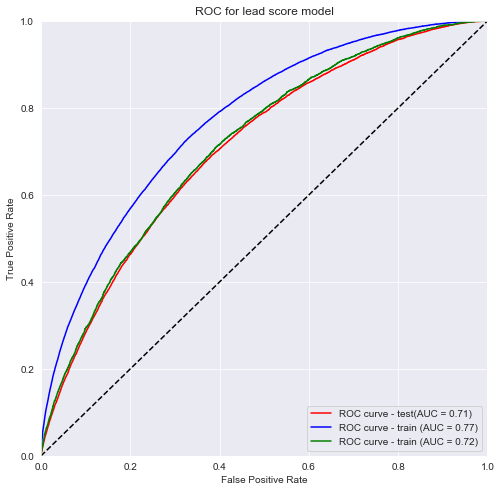

In [387]:
draw_ROC(gbm, dtrain, dvalid, dtest, y_train, y_valid, y_test)

In [388]:
y_pred = gbm.predict(dtest)

In [389]:
print(y_pred.max(), y_pred.min(), y_pred.mean())

0.7321319 0.0054590236 0.14285085


In [390]:
importance=gbm.get_fscore()

In [391]:
df_importance = pd.DataFrame(importance.items(), columns=['feature', 'fscore'])
df_importance['fscore'] = df_importance['fscore'] / df_importance['fscore'].sum()

In [392]:
df_importance.sort_values(['fscore'], ascending=False, inplace=True)
df_importance

,feature,fscore
3,dti,0.043061
31,installment,0.034045
12,mosinoldilacct,0.032747
39,zipcode,0.032314
4,emptitle_freq,0.030366
37,bcutil,0.029789
0,intrate,0.029212
14,mosinoldrevtlop,0.028058
41,revolutil,0.026471
21,bcopentobuy,0.025606
